In [55]:
import generate_raw
import process_data
import model_data
import json
import pandas as pd
import numpy as np
from datetime import time as dttime
from datetime import timedelta, datetime, date
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utils
import json


with open('all_ocd_pts.json', 'r') as f:
    patient_info = json.load(f)

pts = ['B001', 'B002', 'B004', 'B005', 'B006', 'B007', 'B008', 'B009', 'B010', 'B011', 'B012', 'B013', 'B014', 'B015', 'B017', 'B019', 'B020', 'DBSOCD001', 'DBSOCD002', 'U001', 'U003', 'U004']


In [56]:
df_final = pd.DataFrame()
for pt in ['AA04']:
    raw_df, pt_changes_df = generate_raw.generate_raw(pt, patient_info[pt])
    processed_data = process_data.process_data(pt, raw_df, patient_info[pt])
    df_w_preds = model_data.model_data(processed_data)
    df_final = pd.concat([df_final, df_w_preds], ignore_index=True)

In [49]:
df = df_w_preds

In [51]:
model = 'OvER'
hemisphere = 'left'
patient = 'U004'

pt_df = df.query('pt_id == @patient')
days = pt_df.groupby('days_since_dbs').head(1)['days_since_dbs']
t = pt_df['CT_timestamp']
OG = pt_df[f'lfp_{hemisphere}_filled_{model}']
linAR = pt_df[f'lfp_{hemisphere}_preds_{model}']
res = pt_df[f'lfp_{hemisphere}_residuals_{model}']
linAR_R2 = pt_df.groupby('days_since_dbs').head(1)[f'lfp_{hemisphere}_day_r2_{model}']
state_labels = pt_df.groupby('days_since_dbs').head(1)['state_label']

# Identify responder and non-responder indices
pre_DBS_idx = np.where(days < 0)[0]

# Responder indices
if 3 in pt_df['state_label']:
    responder_idx = np.where(state_labels == 3)[0]
    unknown_idx = np.where(state_labels == 4)[0]
# Non-responder indices
else:
    non_responder_idx = np.where(state_labels == 2)[0]

# Hypomanic indices
if 1 in pt_df['state_label']:
    hypomanic_idx = np.where(state_labels == 1)[0]

# Identify discontinuities in the days array
start_index = np.where(np.diff(days) > 7)[0] + 1
start_index = np.concatenate(([0], start_index, [len(days)]))

# Create figure with subplots
fig = make_subplots(
    rows=2, cols=4,
    row_heights=[0.5, 0.5],
    column_widths=[0.3, 0.35, 0.35, 0.1],
    specs=[[{"colspan": 4}, None, None, None],
            [{"colspan": 3}, None, None, {"colspan": 1}]],
    subplot_titles=("Full Time-Domain Plot", "Zoomed Pre-DBS", "Zoomed Post-DBS",
                    "Linear AR R² Over Time", "Linear AR R² Violin Plot"))

# Set plot aesthetics
grid_color = '#a0a0a0'
title_font_color = '#2e2e2e'
axis_title_font_color = '#2e2e2e'
axis_line_color = '#2e2e2e'
plot_bgcolor = 'rgba(240, 240, 240, 1)'
paper_bgcolor = 'rgba(240, 240, 240, 1)'
c_preDBS = 'rgba(255, 215, 0, 0.5)'
c_responder = 'rgba(0, 0, 255, 1)'
c_disinhibited = '#ff0000'
c_nonresponder = 'rgba(255, 185, 0, 1)'
c_dots = 'rgba(128, 128, 128, 0.5)'
c_linAR = 'rgba(51, 160, 44, 1)'
c_OG = 'rgba(128, 128, 128, 0.7)'
sz = 5
ylim_LFP = [-2, 6]
ylim_R2 = [-49, 90]
ema_skip = 3

fig.update_layout(
    paper_bgcolor=paper_bgcolor,
    plot_bgcolor=plot_bgcolor,
    annotations=[dict(
        text='',
        xref='paper',
        yref='paper',
        x=0,
        y=1,
        showarrow=False,
        font=dict(
            size=20,
            color=title_font_color,
            family="Helvetica"
        )
    )]
)

In [52]:
# Plot Full Time-Domain Plot
for i in range(len(start_index) - 1):
    segment_days = np.ravel(days[start_index[i]+1:start_index[i+1]])
    segment_OG = pt_df.query('days_since_dbs in @segment_days')[f'lfp_{hemisphere}_z_scored_{model}']
    segment_linAR = pt_df.query('days_since_dbs in @segment_days')[f'lfp_{hemisphere}_preds_{model}']
    segment_times = pt_df.query('days_since_dbs in @segment_days')['CT_timestamp']

    mask = ~np.isnan(segment_times) & ~np.isnan(segment_OG)
    valid_indices = np.where(mask)[0]
    
    if len(valid_indices) > 0:
        segments = np.split(valid_indices, np.where(np.diff(valid_indices) != 1)[0] + 1)
        
        for segment in segments:
            if len(segment) > 0:
                fig.add_trace(go.Scatter(
                    x=segment_times.values[segment],
                    y=segment_OG.values[segment],
                    mode='lines',
                    line=dict(color=c_OG, width=1),
                    showlegend=False
                ), row=1, col=1)

    linAR_mask = ~np.isnan(segment_times) & ~np.isnan(segment_linAR)
    valid_indices = np.where(mask)[0]
    
    if len(valid_indices) > 0:
        segments = np.split(valid_indices, np.where(np.diff(valid_indices) != 1)[0] + 1)
        
        for segment in segments:
            if len(segment) > 0:
                fig.add_trace(go.Scatter(
                    x=segment_times.values[segment],
                    y=segment_linAR.values[segment],
                    mode='lines',
                    line=dict(color=c_linAR, width=1),
                    showlegend=False
                ), row=1, col=1)

linAR_t = pt_df.dropna(subset=[f'lfp_{hemisphere}_preds_{model}'])['CT_timestamp']
#fig.add_trace(go.Scatter(x=linAR_t, y=pt_df.dropna(subset=[f'lfp_{hemisphere}_preds_{model}'])[f'lfp_{hemisphere}_preds_{model}'], mode='lines', name="Linear AR", line=dict(color=c_linAR, width=1.5), showlegend=False), row=1, col=1)                
fig.update_yaxes(title_text="9 Hz LFP (mV)", row=1, col=1, tickfont=dict(color=axis_title_font_color), titlefont=dict(color=axis_title_font_color), showline=True, linecolor=axis_line_color)
fig.update_xaxes(tickfont=dict(color=axis_title_font_color), titlefont=dict(color=axis_title_font_color), showline=True, linecolor=axis_line_color)

In [53]:
 # Linear AR R² Over Time
for i in range(len(start_index) - 1):
    segment_days = days.values[start_index[i]+1:start_index[i+1]]
    segment_linAR_R2 = linAR_R2.values[start_index[i]+1:start_index[i+1]]
    
    # Plot the dots
    fig.add_trace(go.Scatter(
        x=segment_days,
        y=segment_linAR_R2,
        mode='markers',
        marker=dict(color=c_dots, size=sz),
        showlegend=False
    ), row=2, col=1)
    
color_dict = {0: c_preDBS, 1: c_disinhibited, 2: c_nonresponder, 3: c_responder, 4: c_dots}

for color in color_dict.keys():
    if color not in pt_df['state_label']:
        continue    
    state_df = pt_df.query('state_label == @color')
    state_days = state_df.groupby('days_since_dbs').head(1)['days_since_dbs']
    state_r2 = state_df.groupby('days_since_dbs').head(1)[f'lfp_{hemisphere}_day_r2_{model}']

    fig.add_trace(go.Scatter(
        x=state_days,
        y=state_r2.rolling(window=5, min_periods=1).mean(),
        mode='lines',
        line=dict(color=color_dict[color]),
        showlegend=False
    ), row=2, col=1)

fig.update_yaxes(title_text="Linear AR R²", range=(-0.5, 1), row=2, col=1, tickfont=dict(color=axis_title_font_color), titlefont=dict(color=axis_title_font_color), showline=True, linecolor=axis_line_color)
fig.update_xaxes(tickfont=dict(color=axis_title_font_color), titlefont=dict(color=axis_title_font_color), showline=True, linecolor=axis_line_color)

In [54]:
# Linear AR R² Violin Plot
VIOLIN_WIDTH = 7.0
fig.add_trace(go.Violin(
        y=pt_df.query('state_label == 0').groupby('days_since_dbs').head(1)[f'lfp_{hemisphere}_day_r2_{model}'],
        name='', 
        side='negative', 
        line_color=c_preDBS, 
        fillcolor=c_preDBS,
        showlegend=False,
        width=VIOLIN_WIDTH,
        meanline_visible=True, 
        meanline=dict(color='black', width=2)
    ), row=2, col=4)

if 'Responder' in pt_df['state_label_str']:
    fig.add_trace(go.Violin(
        y=pt_df.query('state_label == 3').groupby('days_since_dbs').head(1)[f'lfp_{hemisphere}_day_r2_{model}'],  
        side='positive', 
        line_color=c_responder, 
        fillcolor=c_responder,
        showlegend=False,
        width=VIOLIN_WIDTH,
        meanline_visible=True, 
        meanline=dict(color='white', width=2)
    ), row=2, col=4)
elif 'Non-responder' in pt_df['state_label_str']:
    fig.add_trace(go.Violin(
        y=pt_df.query('state_label == 2').groupby('days_since_dbs').head(1)[f'lfp_{hemisphere}_day_r2_{model}'], 
        side='positive', 
        line_color=c_nonresponder, 
        fillcolor=c_nonresponder,
        showlegend=False,
        width=VIOLIN_WIDTH,
        meanline_visible=True, 
        meanline=dict(color='black', width=2)
    ), row=2, col=4)

fig.update_yaxes(range=(-0.5, 1), row=2, col=4, tickfont=dict(color=axis_title_font_color), titlefont=dict(color=axis_title_font_color), showline=True, linecolor=axis_line_color)
fig.update_xaxes(tickfont=dict(color=axis_title_font_color), titlefont=dict(color=axis_title_font_color), showline=True, linecolor=axis_line_color)

In [58]:
TIME_INDEX = [dttime(i // 60, i % 60) for i in range(0, 1440, 10)]
df_vcvs = df_final[(df_final['lead_location'] == 'VC/VS') | (df_final['lead_location'] == 'OTHER')]
pt_lfp_dfs = {}
pt_pred_dfs = {}
pt_res_dfs = {}

for pt in ['AA04']:
    pt_df = df_vcvs[df_vcvs['pt_id'] == pt]
    days = pt_df['days_since_dbs'].drop_duplicates().dropna()

    pt_lfp = pd.DataFrame(columns = days, index = TIME_INDEX)
    pt_pred = pd.DataFrame(columns = days, index = TIME_INDEX)
    pt_res = pd.DataFrame(columns = days, index = TIME_INDEX)

    for day in days:
        day_df = pt_df[pt_df['days_since_dbs'] == day]
        day_df.loc[:,'time_bin'] = day_df['time_bin'] - pd.Timedelta(6, unit='h')
        day_df['time_bin'] = day_df['time_bin'].dt.time
        for time_bin, value in day_df[['time_bin', 'lfp_left_z_scored_OvER']].values:
            if time_bin in pt_lfp.index:
                pt_lfp.loc[time_bin, day] = value
        for time_bin, value in day_df[['time_bin', 'lfp_left_preds_OvER']].values:
            if time_bin in pt_pred.index:
                pt_pred.loc[time_bin, day] = value
        for time_bin, value in day_df[['time_bin', 'lfp_left_residuals_OvER']].values:
            if time_bin in pt_res.index:
                pt_res.loc[time_bin, day] = value
        
    
    pt_lfp_dfs[pt] = pt_lfp
    pt_pred_dfs[pt] = pt_pred
    pt_res_dfs[pt] = pt_res
            

C:\Users\jeffr\AppData\Local\Temp\ipykernel_37524\1232574612.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jeffr\AppData\Local\Temp\ipykernel_37524\1232574612.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jeffr\AppData\Local\Temp\ipykernel_37524\1232574612.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [59]:
with pd.ExcelWriter("C:/Users/jeffr/Box/provenza lab/DBS_OCD/Percept-predictability/Causal2_Compare.xlsx", mode = 'a', if_sheet_exists = 'replace', engine = 'openpyxl') as writer:
    for pt in ['AA04']:
        pt_lfp_dfs[pt].to_excel(writer, sheet_name=f'{pt}_LFP')
        pt_pred_dfs[pt].to_excel(writer, sheet_name=f'{pt}_Pred')
        pt_res_dfs[pt].to_excel(writer, sheet_name=f'{pt}_Res')

In [60]:
def get_summary_stats(day, threshold, day_data, pt_df):
    if day_data['lfp_left_day_r2_OvER'].isnull().all():
        return pt_df
    # Add r2 and unthresholded residual features to pt_df
    #pt_df.loc['AR1_r2', day] = day_data['lfp_left_day_r2'].dropna().drop_duplicates().item()

    pt_df.loc['lambda_0', day] = day_data['lfp_left_residuals_OvER'].count() / (day_data['lfp_left_residuals_OvER'].shape[0]/144)
    pt_df.loc['mu_0', day] = day_data['lfp_left_residuals_OvER'].mean()
    pt_df.loc['sigma_0', day] = day_data['lfp_left_residuals_OvER'].var()

    pt_df.loc['mae', day] = np.absolute(day_data['lfp_left_z_scored_OvER'] - day_data['lfp_left_preds_OvER']).mean()

    # Compute residual mask and remove values
    """ l_mask = (day_data['lfp_left_residuals'] < -1*threshold) & (day_data['lfp_left_residuals'] > threshold)
    
    day_data['lfp_left_residuals'][l_mask] = np.nan """

    day_data.loc[(day_data['lfp_left_residuals_OvER'] > -1 * threshold) & (day_data['lfp_left_residuals_OvER'] < threshold), 'lfp_left_residuals_OvER'] = np.nan


    if day_data['lfp_left_residuals_OvER'].isnull().all():
        if not day_data['lfp_left_preds_OvER'].isnull().all():
            pt_df.loc[f'lambda_{threshold}', day] = 0
            pt_df.loc[f'mu_{threshold}', day] = 0
            pt_df.loc[f'sigma_{threshold}', day] = 0

    else:
    # Add thresholded residual features to pt_df
        pt_df.loc[f'lambda_{threshold}', day] = day_data['lfp_left_residuals_OvER'].count() / (day_data['lfp_left_residuals_OvER'].shape[0]/144)
        pt_df.loc[f'mu_{threshold}', day] = day_data['lfp_left_residuals_OvER'].mean()
        pt_df.loc[f'sigma_{threshold}', day] = 0 if np.round(pt_df.loc[f'lambda_{threshold}', day], 0) == 1 else day_data['lfp_left_residuals_OvER'].var()

    return pt_df

In [61]:
pt_summary_stats = {}
threshold = 2.5

for pt in ['AA04']:
    # Subset patient data
    pt_data = df_vcvs[df_vcvs['pt_id'] == pt]
    days = pt_data['days_since_dbs'].drop_duplicates().dropna()
    
    # Initialize patient summary stats dataframe
    pt_df = pd.DataFrame(index=['State_Label',
                                'lambda_0', 'mu_0', 'sigma_0', 
                                f'lambda_{threshold}', f'mu_{threshold}', f'sigma_{threshold}'],
                                  columns=days)
    
    # Compute and assign summary stats for each day
    for day in days:
        day_data = pt_data[pt_data['days_since_dbs'] == day]

        pt_df.loc['State_Label', day] = day_data['state_label'].head(1).item() #add_state_labels(pt, day) # 
        if not day_data.empty:
            pt_df.loc['r2', day] = day_data['lfp_left_day_r2_OvER'].head(1).item()
            #pt_df.loc['State_Label', day] = day_data['state_label'].head(1).item()
        pt_df = get_summary_stats(day, threshold, day_data, pt_df)
    
    # Add summary stats to dictionary
    pt_summary_stats[pt] = pt_df

pt_summary_stats.keys()

dict_keys(['AA04'])

In [62]:
with pd.ExcelWriter("C:/Users/jeffr/Box/provenza lab/DBS_OCD/Percept-predictability/causal_summary_stats.xlsx", mode = 'a', if_sheet_exists = 'replace', engine = 'openpyxl') as writer:
    for pt in ['AA04']:
        pt_summary_stats[pt].to_excel(writer, sheet_name=f'{pt}')

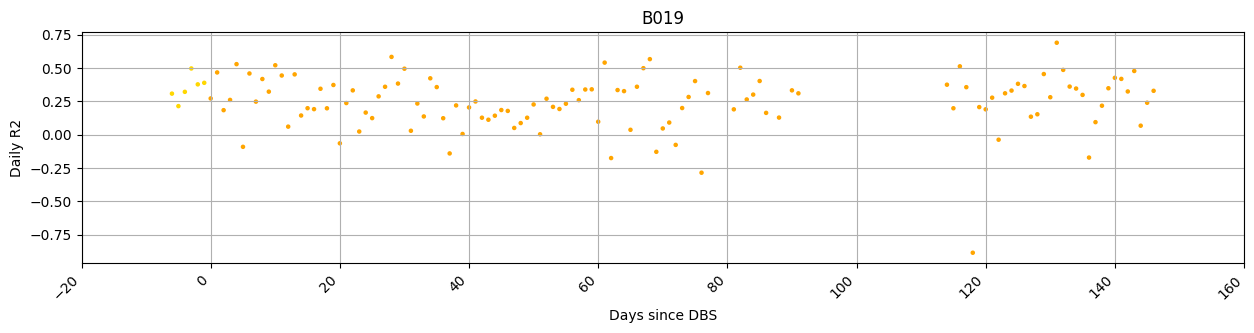

In [ ]:
import matplotlib.pyplot as plt



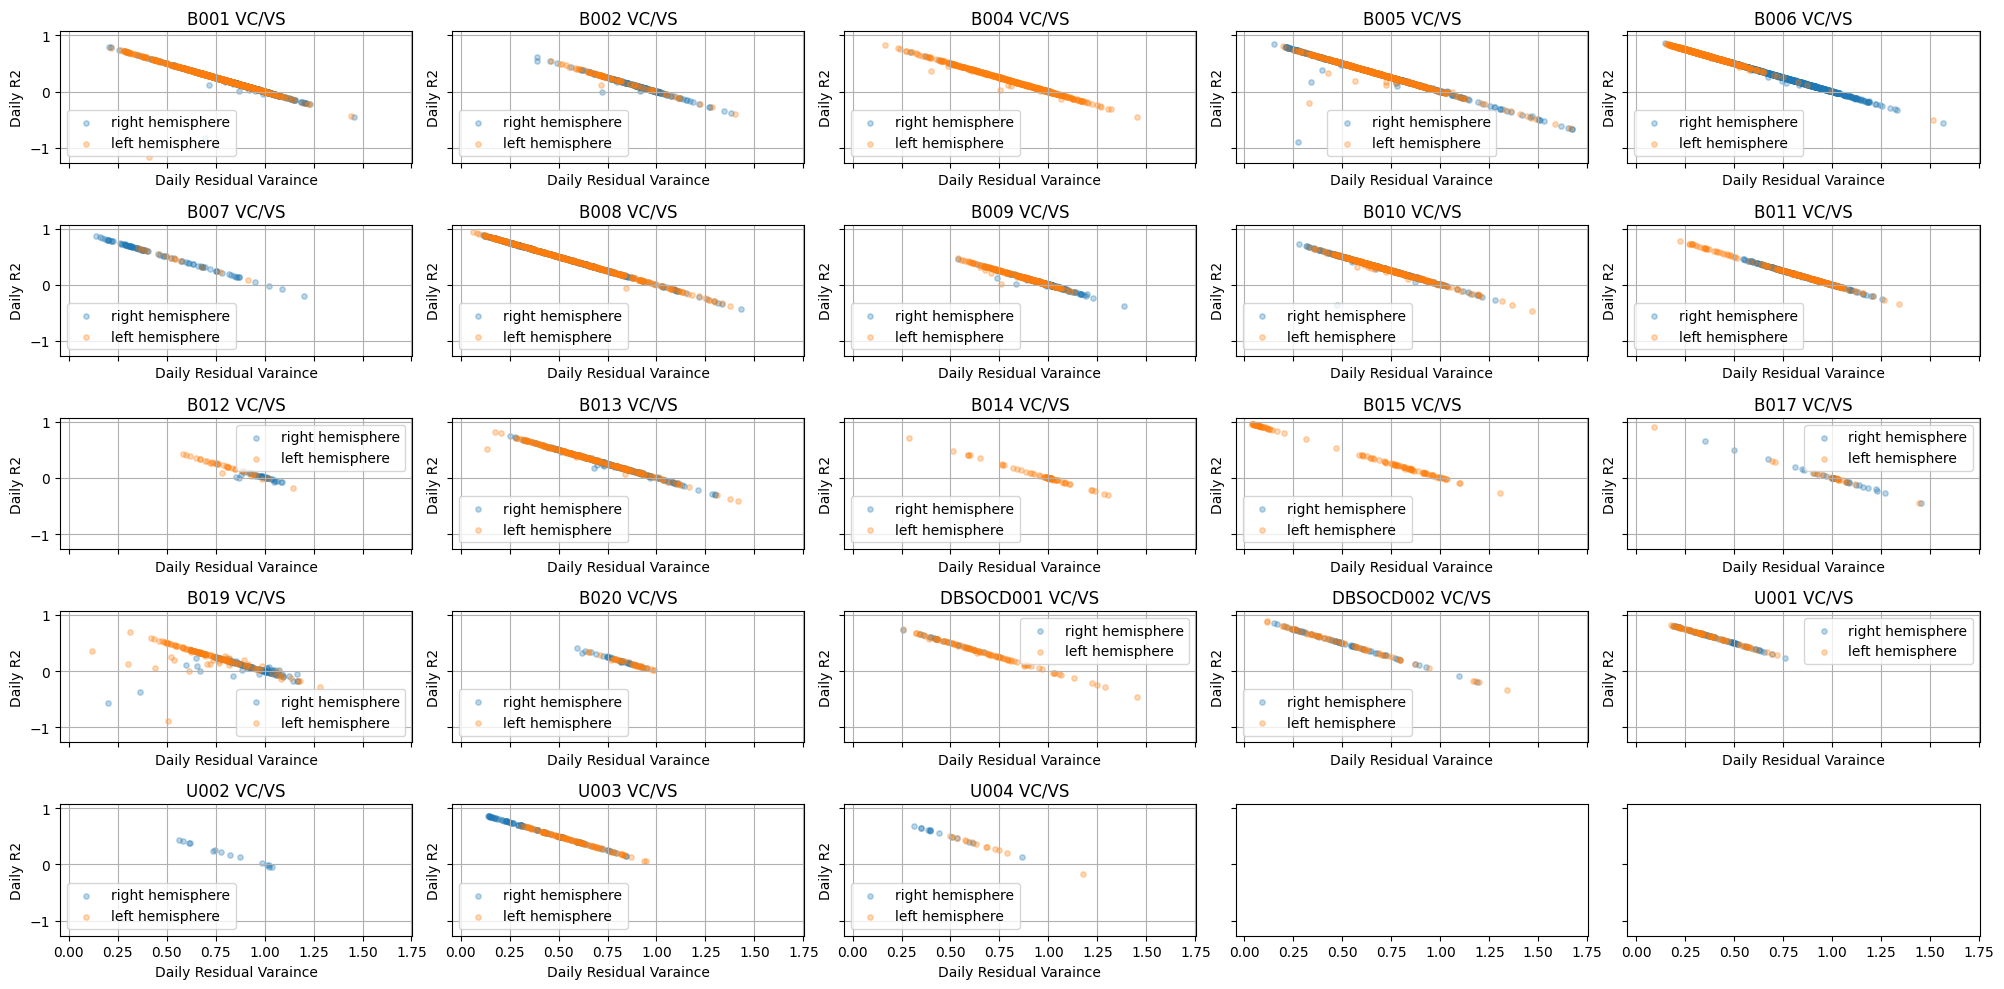

In [22]:
plotting_df = df_final.query('lead_location == "VC/VS" or lead_location == "OTHER"').dropna(subset=['lfp_left_day_r2_OvER', 'lfp_right_day_r2_OvER'], how='all').groupby(['pt_id', 'lead_location', 'days_since_dbs']).head(1)
groups = plotting_df.groupby(['pt_id', 'lead_location'])
ncols=5
fig, axs = plt.subplots(ncols=ncols, nrows=np.ceil(groups.ngroups/ncols).astype(int), figsize=(20, 10), sharex=True, sharey=True)
for ax, ((pt_id, lead_location), group_df) in zip(axs.flatten(), groups):
    ax.scatter(group_df['lfp_right_residual_var_OvER'], group_df['lfp_right_day_r2_OvER'], marker='o', s=15, alpha=0.3, edgecolors='C0', label='right hemisphere')
    ax.scatter(group_df['lfp_left_residual_var_OvER'], group_df['lfp_left_day_r2_OvER'], marker='o', s=15, alpha=0.3, edgecolors='C1', label='left hemisphere')
    ax.legend()
    ax.grid()
    ax.set(title=f'{pt_id} {lead_location}', xlabel='Daily Residual Varaince', ylabel='Daily R2')
fig.tight_layout()
plt.show()